# 高级剪切几何

完全不会CV，所以在二阶段出提示之前完全不知道要做什么。

### Flag 1

> 如果无法访问 HuggingFace 可使用镜像。建议在有 CUDA 的环境解题，如 Out of Memory 可以降低 batch size。

太有用了！Flag 1 的第一个挑战是把模型跑起来。总之我试了一个小时没在Mac把程序跑起来，然后放到GPU服务器上跑了。

> 请先用附件 clip_classifier.py 中的 Classifier 使用默认参数识别每张图片，每张图片会提供 hint 的一个 bit，cat 为 0，dog 为 1，将所有 bit 拼接起来（LSB-first，先放低位再放高位）可以拿到 hint。

> 根据 hint 的指示，可以再从每张图片获取到 flag 的一个 bit。为了提供一定的容错，拼接起来后可以得到将 flag 重复 3 遍的字符串。

很好，我们先跑吧。

In [1]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

import torch
import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor
from typing import List
from PIL import Image

class Classifier(nn.Module):
    """
    A PyTorch module that uses the CLIP model to classify images as 'cat' or 'dog'.

    This classifier computes image features and compares them against pre-computed
    text features for "a photo of a cat" and "a photo of a dog", and return the
    resulting similarities (logits). Note that they don't sum up to 1.
    """

    def __init__(
        self,
        model: str = "openai/clip-vit-base-patch16",
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
    ):
        """
        Initializes the Classifier, loads the CLIP model and processor,
        and pre-computes text features.

        You can set `local_files_only=True` after downloading it for
        the first time to avoid network requests to huggingface.
        """
        super().__init__()
        self.device = device

        # Load the pre-trained CLIP model and its processor
        # You can set `local_files_only=True` to avoid
        # network requests to huggingface
        self.model = CLIPModel.from_pretrained(model, local_files_only=False).to(self.device)
        self.processor = CLIPProcessor.from_pretrained(model, local_files_only=False)

        # Define the text labels for classification
        self.labels = ["a photo of a cat", "a photo of a dog"]

        # Process the text labels and compute their features.
        # This is done within torch.no_grad() to ensure the resulting tensor
        # does not require gradients.
        text_inputs = self.processor(text=self.labels, return_tensors="pt", padding=True).to(self.device)
        with torch.no_grad():
            text_features = self.model.get_text_features(**text_inputs)
        text_features = text_features.requires_grad_(False)

        # Register text features as a buffer. Buffers are part of the module's state
        # but are not considered model parameters.
        self.register_buffer('text_features', text_features)

    def preprocess(self, images: List[Image.Image]) -> torch.Tensor:
        """
        Preprocesses a list of PIL images into a tensor suitable for the CLIP model.

        Args:
            images: A list of PIL Images.

        Returns:
            A tensor of pixel values ready to be fed into the forward method.
        """
        inputs = self.processor(images=images, return_tensors="pt", padding=True)
        return inputs['pixel_values'].to(self.device)

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        """
        Performs the forward pass of the classifier using pre-processed image tensors.

        Args:
            pixel_values: A batch of pre-processed image tensors of the size
                          expected by the CLIP model (e.g., Bx3x224x224).

        Returns:
            A tensor of shape (B, 2) on the same device as the model, where B is
            the batch size. Each row contains the logits for the
            classes [cat, dog].
        """
        # Extract image features using the CLIP model.
        # Gradients will be computed for this part if requires_grad is True.
        image_features = self.model.get_image_features(pixel_values=pixel_values)

        # Normalize both image and text features for cosine similarity calculation.
        # self.text_features is a buffer and does not require gradients.
        image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        text_features = self.text_features / self.text_features.norm(p=2, dim=-1, keepdim=True)

        # Calculate the cosine similarity between image and text features.
        # This results in the logits for each class.
        # (B, 512) @ (512, 2) -> (B, 2)
        logits = image_features @ text_features.t()

        return logits

In [2]:
# This block demonstrates how to use the Classifier class.
# It will be executed only when the script is run directly.
import requests

print("Running a quick demonstration of the Classifier.")

# Initialize the classifier
classifier = Classifier()
print(f"Classifier is running on device: {classifier.device}")

# URL of a sample image (a cat)
url = "http://images.cocodataset.org/val2017/000000039769.jpg"

# Download and open the image
image = Image.open(requests.get(url, stream=True).raw)

# The classifier expects a batch, so we wrap the single image in a list
image_batch = [image]

# 1. Preprocess the image(s) to get the required tensor
pixel_values = classifier.preprocess(image_batch)
print(f"\nImage tensor shape after preprocessing: {pixel_values.shape}")

# 2. Pass the pre-processed tensor to the forward method
logits = classifier(pixel_values)

# Move the output tensor to the CPU for printing and further processing
# if it was computed on a different device.
logits_cpu = logits.cpu().detach()

print(f"Image URL: {url}")
print(f"Logits (cat=0, dog=1): {logits_cpu.numpy()}")

# Determine the predicted class
predicted_index = torch.argmax(logits_cpu, dim=1).item()
predicted_label = ["cat", "dog"][predicted_index]

print(f"Predicted class: {predicted_label} ({predicted_index})")

Running a quick demonstration of the Classifier.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x799eada3e520>
Traceback (most recent call last):
  File "/fast/hrz/geekgame25/.venv/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/fast/hrz/geekgame25/.venv/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'disp'


Classifier is running on device: cuda

Image tensor shape after preprocessing: torch.Size([1, 3, 224, 224])
Image URL: http://images.cocodataset.org/val2017/000000039769.jpg
Logits (cat=0, dog=1): [[0.22737029 0.15659843]]
Predicted class: cat (0)


In [27]:
from tqdm.auto import tqdm
from PIL import Image
from glob import glob

_all_indexes = []

# Download and open the image
for f in tqdm([f"flag1_images/{i}.png" for i in range(1416)]):
    image = Image.open(f)

    # The classifier expects a batch, so we wrap the single image in a list
    image_batch = [image]

    # 1. Preprocess the image(s) to get the required tensor
    pixel_values = classifier.preprocess(image_batch)
    print(f"\nImage tensor shape after preprocessing: {pixel_values.shape}")

    # 2. Pass the pre-processed tensor to the forward method
    logits = classifier(pixel_values)

    # Move the output tensor to the CPU for printing and further processing
    # if it was computed on a different device.
    logits_cpu = logits.cpu().detach()

    print(f"Image URL: {url}")
    print(f"Logits (cat=0, dog=1): {logits_cpu.numpy()}")

    # Determine the predicted class
    predicted_index = torch.argmax(logits_cpu, dim=1).item()
    _all_indexes.append(predicted_index)

_all_indexes

  0%|          | 0/1416 [00:00<?, ?it/s]


Image tensor shape after preprocessing: torch.Size([1, 3, 224, 224])
Image URL: http://images.cocodataset.org/val2017/000000039769.jpg
Logits (cat=0, dog=1): [[0.20868392 0.28526396]]

Image tensor shape after preprocessing: torch.Size([1, 3, 224, 224])
Image URL: http://images.cocodataset.org/val2017/000000039769.jpg
Logits (cat=0, dog=1): [[0.19774562 0.2593973 ]]

Image tensor shape after preprocessing: torch.Size([1, 3, 224, 224])
Image URL: http://images.cocodataset.org/val2017/000000039769.jpg
Logits (cat=0, dog=1): [[0.26521993 0.24166216]]

Image tensor shape after preprocessing: torch.Size([1, 3, 224, 224])
Image URL: http://images.cocodataset.org/val2017/000000039769.jpg
Logits (cat=0, dog=1): [[0.25373667 0.25131765]]

Image tensor shape after preprocessing: torch.Size([1, 3, 224, 224])
Image URL: http://images.cocodataset.org/val2017/000000039769.jpg
Logits (cat=0, dog=1): [[0.28174558 0.21175286]]

Image tensor shape after preprocessing: torch.Size([1, 3, 224, 224])
Image

[1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
...
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 ...]

In [ ]:
def _make_byte(l):
    byte = 0
    _splited_bytes = [l[i:i+8] for i in range(0, len(l), 8)]
    _all_bytes = b''
    for _b in _splited_bytes:
        byte = 0
        for j in range(7, -1, -1):
            byte = (byte << 1) | _b[j]
        _all_bytes += bytes([byte])
    return _all_bytes

_make_byte(_all_indexes)

b"Congrats! You've made the`classifier to work, but some of the images a2e \xe1ttacked.\nYou need to detect them and concatenape 0=unattacked/1=attacked to get the real flae.\n\x00\x00\x00\x00\x00\x00\x00\x00"

> flag1：可以了解一下 attack transferability。由于攻击是针对特定模型完成的，该攻击对于其他模型仅仅是加入了噪音，所以可以使用其他模型拿到 ground truth。CLIP 家族有不止一个模型，用另外一个模型识别即可。

好，我们得到提示了。去Huggingface上随便找一个CLIP家族的模型跑一下，算个diff，然后flag救出了。

In [ ]:
from tqdm.auto import tqdm
from PIL import Image

MODEL2 = "zer0int/CLIP-GmP-ViT-L-14"

classifier2 = Classifier(model=MODEL2)

_all_indexes2 = []

# Download and open the image
for f in tqdm([f"flag1_images/{i}.png" for i in range(1416)]):
    image = Image.open(f)

    # The classifier expects a batch, so we wrap the single image in a list
    image_batch = [image]

    # 1. Preprocess the image(s) to get the required tensor
    pixel_values = classifier2.preprocess(image_batch)
    print(f"\nImage tensor shape after preprocessing: {pixel_values.shape}")

    # 2. Pass the pre-processed tensor to the forward method
    logits = classifier2(pixel_values)

    # Move the output tensor to the CPU for printing and further processing
    # if it was computed on a different device.
    logits_cpu = logits.cpu().detach()

    print(f"Image URL: {url}")
    print(f"Logits (cat=0, dog=1): {logits_cpu.numpy()}")

    # Determine the predicted class
    predicted_index = torch.argmax(logits_cpu, dim=1).item()
    _all_indexes2.append(predicted_index)

_all_indexes2

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1416 [00:00<?, ?it/s]


Image tensor shape after preprocessing: torch.Size([1, 3, 224, 224])
Image URL: http://images.cocodataset.org/val2017/000000039769.jpg
Logits (cat=0, dog=1): [[0.10745329 0.2458489 ]]

Image tensor shape after preprocessing: torch.Size([1, 3, 224, 224])
Image URL: http://images.cocodataset.org/val2017/000000039769.jpg
Logits (cat=0, dog=1): [[0.18541843 0.07525163]]

Image tensor shape after preprocessing: torch.Size([1, 3, 224, 224])
Image URL: http://images.cocodataset.org/val2017/000000039769.jpg
Logits (cat=0, dog=1): [[0.12178209 0.2234237 ]]

Image tensor shape after preprocessing: torch.Size([1, 3, 224, 224])
Image URL: http://images.cocodataset.org/val2017/000000039769.jpg
Logits (cat=0, dog=1): [[0.1918175  0.18418194]]

Image tensor shape after preprocessing: torch.Size([1, 3, 224, 224])
Image URL: http://images.cocodataset.org/val2017/000000039769.jpg
Logits (cat=0, dog=1): [[0.21539617 0.09986823]]

Image tensor shape after preprocessing: torch.Size([1, 3, 224, 224])
Image

[1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
...
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 ...]

In [30]:
_diff_bytes = [1 if _all_indexes[i] != _all_indexes2[i] else 0 for i in range(len(_all_indexes))]
_make_byte(_diff_bytes)

b'fhag{M4\xd9_7h3_7orch_a7t\x04cKu_bU7_GR0UND\x7fTru6H_q74Nd5_S7i11!}\nflAg{M4Y_7h3_7orch^c7t4cK5_bU7_WR\xb0UND\x1bTru7H_q74N`5_S7i11!m\nflagyM4Y]7h3_7orch_a2t4cK\x15_bU7_GR0UND_Tru7H_s74Nd5][7i11!}\n'

**Flag碎片：**

fhag{M4?_7h3_7orch_a7t?cKu_bU7_GR0UND?Tru6H_q74Nd5_S7i11!}
flAg{M4Y_7h3_7orch^c7t4cK5_bU7_WR?UND?Tru7H_q74N`5_S7i11!m
flagyM4Y]7h3_7orch_a2t4cK?_bU7_GR0UND_Tru7H_s74Nd5][7i11!}

**答案：**

flag{M4Y_7h3_7orch_a7t4cK5_bU7_GR0UND_Tru7H_s74Nd5_S7i11!} 

### Flag 2

> flag2：先试着人肉识别一些图片是否被攻击过，可以发现在一块颜色差不多的区域，被攻击的图片有明显的噪音。预期解使用了 laplacian kernel 作为放大噪音的手段。

我们先尝试让Gemini指导输出一下这些图片的laplacian variance都长什么样。

  0%|          | 0/1344 [00:00<?, ?it/s]

已保存拉普拉斯响应图到: flag2_images/0.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/1.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/2.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/3.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/4.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/5.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/6.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/7.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/8.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/9.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/10.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/11.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/12.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/13.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/14.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/15.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/16.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/17.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/18.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/19.png.laplacian.png
已保存拉普拉斯响应图到: flag2_images/20.png.laplacian.png
已保存拉普拉斯响应图到: flag2_imag

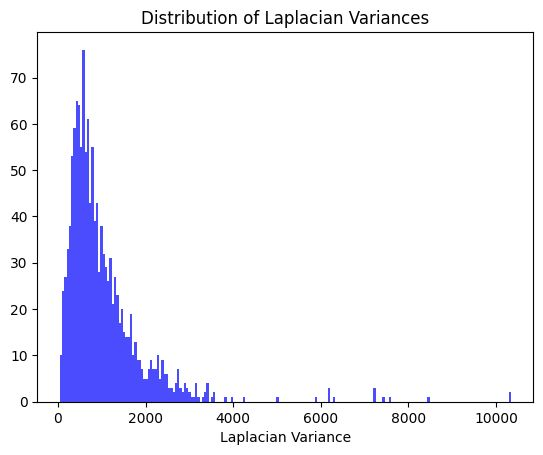

In [105]:
import cv2
import numpy as np
import os

def get_laplacian_variance(image: np.ndarray) -> float:
    """
    计算图像的拉普拉斯方差。
    高方差意味着高频噪声或丰富的边缘细节。
    """
    # 1. 转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 2. 计算拉普拉斯算子
    #    cv2.CV_64F 是使用64位浮点数，以避免计算二阶导数时出现负值被截断
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    
    # 3. 计算方差
    variance = laplacian.var()
    return variance

def simulate_pgd_noise(image: np.ndarray, epsilon: int = 4) -> np.ndarray:
    """
    通过添加均匀分布的微小噪声来模拟PGD攻击的效果。
    PGD的扰动通常被限制在一个L-infinity范数球内 (epsilon)。
    
    注意：这只是一个模拟，真正的PGD是基于梯度的。
    但对于检测目的，这种高频噪声模拟是有效的。
    """
    # 确保数据类型为浮点数以便添加噪声
    image_float = image.astype(np.float32)
    
    # 生成在 [-epsilon, epsilon] 范围内的随机噪声
    noise = np.random.uniform(-epsilon, epsilon, image_float.shape)
    
    # 添加噪声并裁剪到有效的 [0, 255] 像素范围内
    attacked_image = np.clip(image_float + noise, 0, 255)
    
    # 转回uint8以便显示和保存
    return attacked_image.astype(np.uint8)

def visualize_laplacian(image: np.ndarray, output_filename: str):
    """
    可视化拉普拉斯算子的响应并保存为图像。
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    
    # 取绝对值并归一化到 [0, 255] 范围以便可视化
    lap_abs = np.abs(laplacian)
    lap_normalized = cv2.normalize(lap_abs, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    cv2.imwrite(output_filename, lap_normalized)
    print(f"已保存拉普拉斯响应图到: {output_filename}")

_variances = []
for f in tqdm([f"flag2_images/{i}.png" for i in range(1344)]):
    # open file with cv2
    image = cv2.imread(f)
    var_clean = get_laplacian_variance(image)
    _variances.append(var_clean)
    visualize_laplacian(image, f+".laplacian.png")

# plot the distribution of variances
import matplotlib.pyplot as plt

plt.hist(_variances, bins=200, color='blue', alpha=0.7)
plt.title('Distribution of Laplacian Variances')
plt.xlabel('Laplacian Variance')
plt.show()

In [66]:
THRESHOLD = 900  # 根据上图选择一个合适的阈值

_detected_bytes = [1 if _var > THRESHOLD else 0 for _var in _variances]
_make_byte(_detected_bytes)

b'\xde@\x86\x01\xecqQ\x0e\xaa\x08\xd1\xe1E\xb6{\xcd\xa1\xc2A\x86Q\xac\x99\x07\x9f\x92\xaa@)\xcbeB\x80\x1cC\xc2\x94\xd88K\xd8T\xc8\x99\x066B\x08\x00CQ\x05\x16Z\xf6s\xed8\xea\x84\nc`\xa4W\x15\xca(]D\x91h\xf3\xec\xd0E(\x18\xb1\n\tK\r\xa8\x88\x93d1Q\x94v\xa0G\xc6\xa81|o\xd0DI\x16I\x13\x19\xca\x88\x1d\xf7\xd0I\xc4\xa2\x06g0\x02.<c[\xf1\xd2\xaa`4\xd8\x88\x049p\x04\x97\xc0\xb1\x82\xec,C\xcf0_\x8a\xb3t\xc5\x87\x08l\xc8\x04\x15\xf9VBB\x19\x92\xe9`\x07\xe4\x1a\xc3\x84\x94h\xe0'

很明显我们没法从整张图的Variance得出图片是否被攻击过，那不如人工观察一下这些图片。

这是一张没有被攻击的图片：

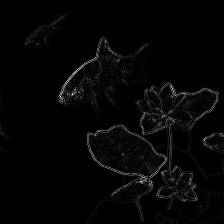

这是一张被攻击过的图片：

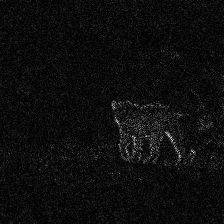

仔细观察可以发现攻击过的图片全图都存在一片椒盐一样的噪点，而没有被攻击过的图片总有些背景区域的Variance基本是0。一个很自然的思路是，我们遍历全图，找最小的16*16区域的Variance的值。

  0%|          | 0/1344 [00:00<?, ?it/s]

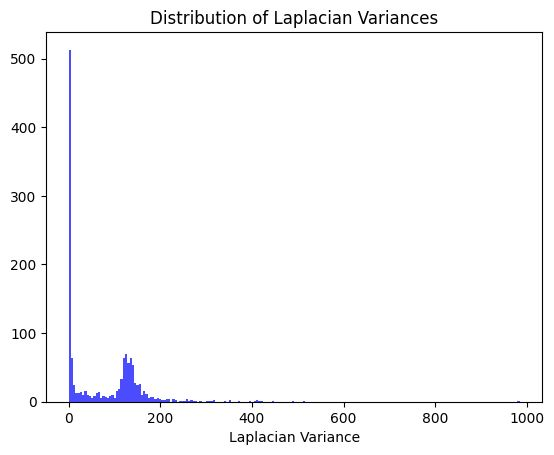

In [166]:
import cv2
import numpy as np
import os

def find_min_laplacian_variance(image: np.ndarray, patch_size: int = 16, stride: int = 2) -> float:
    """
    在整张图上滑动一个 patch_size 大小的窗口，
    计算每个窗口的拉普拉斯方差，并返回*最小*的那个方差值。
    
    :param image: 输入图像 (BGR)
    :param patch_size: 窗口大小 (例如 20x20)
    :param stride: 滑动步长 (为了加快计算，可以不设为1)
    :return: 最小的拉普拉斯方差 (噪音下限)
    """
    
    # 1. 最高效的方法：先计算 *整张图* 的拉普拉斯响应
    #    我们不需要在循环内反复计算小块的拉普拉斯
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_full = cv2.Laplacian(gray, cv2.CV_64F)
    
    h, w = laplacian_full.shape
    min_found_variance = np.inf # 初始化一个无穷大的值
    
    # 2. 在拉普拉斯响应图上滑动窗口
    for y in range(0, h - patch_size, stride):
        for x in range(0, w - patch_size, stride):
            # 提取 20x20 的拉普拉斯响应块
            laplacian_patch = laplacian_full[y : y + patch_size, x : x + patch_size]
            
            # 3. 计算这个块的方差
            current_variance = laplacian_patch.var()
            
            # 4. 寻找最小值
            if current_variance < min_found_variance:
                min_found_variance = current_variance
                
    return min_found_variance

_variances2 = []
for f in tqdm([f"flag2_images/{i}.png" for i in range(1344)]):
    # open file with cv2
    image = cv2.imread(f)
    var_clean = find_min_laplacian_variance(image)
    _variances2.append(var_clean)

# plot the distribution of variances
import matplotlib.pyplot as plt

plt.hist(_variances2, bins=200, color='blue', alpha=0.7)
plt.title('Distribution of Laplacian Variances')
plt.xlabel('Laplacian Variance')
plt.show()

In [169]:
# report mean, median and quantiles
_variances2_np = np.array(_variances2)
print(f"Mean: {_variances2_np.mean()}")
print(f"Median: {np.median(_variances2_np)}")
print(f"25th Percentile: {np.percentile(_variances2_np, 25)}")
print(f"75th Percentile: {np.percentile(_variances2_np, 75)}")

Mean: 72.44000400815692
Median: 43.55784606933594
25th Percentile: 1.4878654479980469
75th Percentile: 130.70920181274414


In [170]:
THRESHOLD = 50  # 根据上图选择一个合适的阈值

for thresh in range(1, 100):
    _detected_bytes = [1 if _var > thresh else 0 for _var in _variances2]
    print(f"Threshold: {thresh}, Detected bytes: {sum(_detected_bytes)}")
    print(_make_byte(_detected_bytes))

Threshold: 1, Detected bytes: 1055
b'o\xefwo\xff\xff|_\xdf\xd5\xff\xf3\xff~{s\xf1<c\xf97~\xff\xdf\xb7w\xfe\x7fm\xdfr\xf2\xbc^w\xe3\xff\xdf\xff\x7f\xdf~k\xbfo\xb1n|\xce\xff\xdb\xef\x7f\xf7\xfd{\xfe\xff\xfd\xff{\x7f\xfe[\xff\xf5\xfa\xfb\xdf\xee\xfd\xfcq\xffw\xed?\xce\xff_\x7f~\xff\xf5\xff\xff|{}\xdf\xb7\xd3\xff\x7f\xff\x7f\x7fwy7\xfdr\xef\xff^u{\xed\xff\xf2\xff\xef\xe7\x7f}\xe7\xffo\xfd\xff\x7fw\xf8w\x7f\xcf\xf1\xf1s\xbd\xeb\xff\xbf\xdf\x7f\xfb\xf7\xfen\xefm_p\xdfu_\xbb\xdf?\xff]\xf3\xdf\xff}uI{~z\xf6\xf7Z\xff\xff\xf7}\xcb'
Threshold: 2, Detected bytes: 974
b'oowo\xff\xfft_\xdf\xd5\xd9\xf3\xff~{s\xb14c\xf97^\xff\xdf\xb7w\xfe\x7fm\xdfrr\xbcVw\xe3\xbf_u\x7f\xdf~i\xbfo\xb1nx\xc6\xbe[\xef\x7fv\xfd;\xfe\x7f\xed\xe7{\x7f\xf6Y\xff\xf5z{\xdf\xee\xed\xfcq\xffw\xed?\xce\xff_\x7fv\xff\xc5n\xffts}\xd7\xb7S\xff_\xf7{\x7fwy7\xf9r\xee\xffF5[m\xffr\x7f\xefg\x7fm\xe7\xfbo\xf5\xff\x7fu\xf87\x7f\xce\xf1\xf13\xbd\xebm\xbf\xcf\x7f\xfb\xb7\xfan\xcfl_p\xdfuW\xbb\xdb?\xdf]\xf3\xdf\xdf}uI{~z\xf6vZ\xff\xb3\xf7}\x

看着很对！可惜还是有太多乱码位了。

**最佳答案：**

flag{m4Y_TH3_Lip14ca5N_K3rnEl_pR0T3C7_Ur_Vi5I0nxF0Rm3r}

怎么还错了🤯